In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

class NeuralNetwork:

    @staticmethod
    def sigma(x):
        return 1 / (np.exp(-x) + 1)

    @staticmethod
    def sigma_deriv(x):
        sig = NeuralNetwork.sigma(x)
        deriv = sig * (1 - sig)
        return deriv

    @staticmethod
    def softmax(x):
        # softmax function ---------
        t = np.exp(x - np.max(x))
        return t / np.sum(t, axis=1, keepdims=True)

    @staticmethod
    def get_activation_function(name):
        if name == 'sigma':
            return NeuralNetwork.sigma
        elif name == 'linear':
            return lambda x: x
        elif name == 'softmax':
            return NeuralNetwork.softmax
        elif name == 'tanh':
            return np.tanh
        elif name == 'relu':
            return lambda x: np.maximum(0, x)

    @staticmethod
    def get_activation_derivative(name):
        if name == 'sigma':
            return NeuralNetwork.sigma_deriv
        elif name == 'linear':
            return lambda x: np.ones_like(x)
        elif name == 'softmax':
            # jacobian of softmax - unused -------
            def softmax_deriv(x):
                value = NeuralNetwork.softmax(x)
                SM = value.reshape((-1, 1))
                jac = np.diagflat(value) - np.dot(SM, SM.T)
                return jac

            return softmax_deriv
        elif name == 'tanh':
            return lambda x: 1 - np.tanh(x)**2
        elif name == 'relu':
            return lambda x: x > 0


    @staticmethod
    def get_loss_function(name):
        if name == 'mse':
            return lambda x_pred, x: np.linalg.norm(x_pred - x)
        elif name == 'crossentropy':
            return lambda x_pred, x: -np.sum(x*np.log(x_pred))

    @staticmethod
    def get_loss_derivative(name):
        # currently unused
        if name == 'mse':
            return lambda x_pred, x: (x_pred - x)
        elif name == 'crossentropy':
            return lambda x_pred, x: x*(-1/x_pred)

    class Layer:
        def __init__(self, input_width, layer_width, activation_function):
            # self.weights = np.random.uniform(0, 1, (input_width + 1, layer_width))
            self.weights = np.random.normal(0, 1, (input_width + 1, layer_width))
            self.activation_function = activation_function

        def predict(self, x):
            activation_function = NeuralNetwork.get_activation_function(self.activation_function)
            return activation_function(np.dot(x, self.weights))

        def feedforward_step(self, x):
            activation_function = NeuralNetwork.get_activation_function(self.activation_function)
            activation = np.dot(x, self.weights)
            response = activation_function(activation)
            return response, activation

    def __init__(self, input_width, output_width, activation_function='sigma', loss_function='mse', bias_exists=True):
        ###
        # create a new nn object. activation_function specifies activation used on hidden layers
        # loss_function affects loss printed to console
        ###
        self.input_width = input_width
        self.output_width = output_width
        self.layers = []
        self.activation_function = activation_function
        self.loss_function = NeuralNetwork.get_loss_function(loss_function)
        self.loss_derivative = NeuralNetwork.get_loss_derivative(loss_function)
        self.bias_exists = bias_exists

    def add_layer(self, layer_width):
        ###
        # add a hidden layer with specified number of neurons
        ###
        if len(self.layers) == 0:
            self.layers.append(NeuralNetwork.Layer(self.input_width, layer_width, self.activation_function))
        else:
            self.layers.append(
                NeuralNetwork.Layer(self.layers[-1].weights.shape[1], layer_width, self.activation_function))


    def predict(self, x):
        ###
        # predict responses on new data
        ###
        values = np.copy(x)
        for layer in self.layers:
            values = np.hstack((values, np.ones((values.shape[0], 1)) if self.bias_exists else np.zeros((values.shape[0], 1))))
            values = layer.predict(values)
        return values

    def create_output_layer(self, activation_function='linear'):
        ###
        # create output layer with specified activation function. Use after adding all hidden layers and before training
        ###
        if len(self.layers) == 0:
            self.layers.append(NeuralNetwork.Layer(self.input_width, self.output_width, activation_function))
        else:
            self.layers.append(
                NeuralNetwork.Layer(self.layers[-1].weights.shape[1], self.output_width, activation_function))

    def feedforward(self, x):
        response = np.copy(x)
        response = response.reshape(1, -1)
        response = np.hstack((response, np.ones((response.shape[0], 1))))
        response_s = [response]
        activation_s = []
        for i in range(len(self.layers) - 1):
            response, activation = self.layers[i].feedforward_step(response_s[i])
            activation_s.append(activation)
            response = response.reshape(1, -1)
            response = np.hstack((response, np.ones((response.shape[0], 1))))
            response_s.append(response)
        response, activation = self.layers[-1].feedforward_step(response_s[-1])
        activation_s.append(activation)
        response = response.reshape(1, -1)
        response_s.append(response)
        return (response_s, activation_s)

    def backpropagation(self, x, y, r_s, a_s):
        e_s = [None] * len(self.layers)

        ###
        # derivative of loss function in respect to final layer weights
        # assuming loss is crossentropy and output layer is softmax
        # formula is the same as in the case of linear outputs and mse
        ###
        e_s[-1] = a_s[-1] - y

        for i in reversed(range(1, len(e_s))):
            unbiased_weights = self.layers[i].weights[0:(self.layers[i].weights.shape[0] - 1), :]
            e_s[i-1] = NeuralNetwork.get_activation_derivative(self.layers[i-1].activation_function)(a_s[i-1])*(e_s[i].dot(unbiased_weights.T))
        gradient = [r_s[j].T.dot(e_s[j]) for j in range(0, len(self.layers))]
        return gradient

    def train(self, x, y, batch_size=10, epochs=100, lr=0.01, method='basic', method_param=0.0):
        ###
        # train network. method can be 'basic', 'momentum' or 'rmsprop'.
        # method_param specifies lambda in momentum or beta in rmsprop
        ###
        errors = []
        eps = 1e-8
        momentum = [np.zeros(layer.weights.shape) for layer in self.layers]
        for e in range(epochs):
            permutation = np.random.permutation(y.shape[0])
            x = x[permutation, :]
            y = y[permutation, :]
            i = 0
            while i < y.shape[0]:
                deltas = [np.zeros(layer.weights.shape) for layer in self.layers]
                x_batch = x[i:i + batch_size, :]
                y_batch = y[i:i + batch_size, :]
                i = i + batch_size
                for j in range(0, y_batch.shape[0]):
                    r_s, a_s = self.feedforward(x_batch[j, :])
                    gradient = self.backpropagation(x_batch[j, :], y_batch[j, :], r_s, a_s)
                    for k in range(0, len(deltas)):
                        deltas[k] = deltas[k] - gradient[k]

                if method == 'momentum':
                    momentum = [delta + method_param * mom for mom, delta in zip(momentum, deltas)]
                elif method == 'rmsprop':
                    momentum = [method_param * mom + (1 - method_param)*np.square(delta) for mom, delta in zip(momentum, deltas)]

                for j in range(0, len(deltas)):
                    if method == 'momentum':
                        self.layers[j].weights = self.layers[j].weights + lr*momentum[j]
                    elif method == 'rmsprop':
                        self.layers[j].weights = self.layers[j].weights + lr * (deltas[j] / (np.sqrt(momentum[j]) + eps))
                    else:
                        self.layers[j].weights = self.layers[j].weights + lr*deltas[j]

                error = self.loss_function(self.predict(x_batch), y_batch)
                print("loss on batch = {}".format(error))
                errors.append(error)
        return errors


# TESTS ------------------------------------------------------------------------
# set path to dataset folders
classification = "projekt1/classification/"
regression = "projekt1/regression/"

# side functions

def nnerrors(inputw, outputw, activation, X, y, layers1, layers2, layers3, output_activation='linear', loss='mse', epochs=4):
    nn1 = NeuralNetwork(inputw, outputw, activation, loss)
    for layer in layers1:
        nn1.add_layer(layer)
    nn1.create_output_layer(output_activation)
    nn2 = NeuralNetwork(inputw, outputw, activation, loss)
    for layer in layers2:
        nn2.add_layer(layer)
    nn2.create_output_layer(output_activation)
    nn3 = NeuralNetwork(inputw, outputw, activation, loss)
    for layer in layers3:
        nn3.add_layer(layer)
    nn3.create_output_layer(output_activation)

    errors1 = nn1.train(X, y, epochs=epochs, batch_size=50, lr=.02, method='rmsprop', method_param=0.2)
    errors2 = nn2.train(X, y, epochs=epochs, batch_size=50, lr=.02, method='rmsprop', method_param=0.2)
    errors3 = nn3.train(X, y, epochs=epochs, batch_size=50, lr=.02, method='rmsprop', method_param=0.2)

    return [errors1, errors2, errors3]


def make_plots(inputw, outputw, X, y, layers1, layers2, layers3, output_activation, loss, label1, label2, label3, suptitle, ylim=(0, 20), epochs=4):
    np.random.seed(42)
    sigma_error = nnerrors(inputw, outputw, 'sigma', X, y, layers1, layers2, layers3, output_activation, loss, epochs)
    tanh_error = nnerrors(inputw, outputw, 'tanh', X, y, layers1, layers2, layers3, output_activation, loss, epochs)
    relu_error = nnerrors(inputw, outputw, 'relu', X, y, layers1, layers2, layers3, output_activation, loss, epochs)

    x_err = range(len(sigma_error[0]))

    fig, axis = plt.subplots(1, 3, figsize=(10,5))
    plt.setp(axis, ylim=ylim)
    axis[0].plot(x_err, sigma_error[0], label=label1)
    axis[0].plot(x_err, sigma_error[1], label=label2)
    axis[0].plot(x_err, sigma_error[2], label=label3)
    axis[0].set_title('sigma')
    axis[0].set_ylabel(loss)
    axis[1].plot(x_err, tanh_error[0])
    axis[1].plot(x_err, tanh_error[1])
    axis[1].plot(x_err, tanh_error[2])
    axis[1].set_title('tanh')
    axis[2].plot(x_err, relu_error[0])
    axis[2].plot(x_err, relu_error[1])
    axis[2].plot(x_err, relu_error[2])
    axis[2].set_title('relu')
    fig.legend()
    fig.suptitle(suptitle)
    fig.show()

In [26]:
f = open(classification + "data.three_gauss.train.1000.csv")
gauss3train = np.loadtxt(f, delimiter=",", skiprows=1, usecols=(0, 1, 2))
f.close()
X_train = gauss3train[:, 0:2]
y_train = gauss3train[:, 2]
y_train = y_train.reshape(-1, 1)
encoder_gauss3 = OneHotEncoder(sparse=False)
y_gauss3train = encoder_gauss3.fit_transform(y_train)
X_gauss3train = X_train

f = open(classification + "data.three_gauss.test.1000.csv")
gauss3test = np.loadtxt(f, delimiter=",", skiprows=1, usecols=(0, 1, 2))
f.close()
X_test = gauss3test[:, 0:2]
y_test = gauss3test[:, 2]
y_test = y_test.reshape(-1, 1)
y_gauss3test = encoder_gauss3.transform(y_test)
X_gauss3test = X_test


loss on batch = 889.6709922822315
loss on batch = 863.5517287947677
loss on batch = 759.1097609548162
loss on batch = 688.050471707376
loss on batch = 623.3702693520336
loss on batch = 609.2003216789208
loss on batch = 579.5796450362018
loss on batch = 566.7783438523969
loss on batch = 549.3658252902526
loss on batch = 539.1037125470275
loss on batch = 531.5773484091474
loss on batch = 525.4882298017761
loss on batch = 521.4232035123744
loss on batch = 514.9748259319039
loss on batch = 509.12940233001973
loss on batch = 500.2758964205082
loss on batch = 498.252670864241
loss on batch = 489.8115677308871
loss on batch = 486.8843150663923
loss on batch = 473.9837369970215
loss on batch = 468.6668255811827
loss on batch = 461.19827662555844
loss on batch = 458.88836623951147
loss on batch = 450.3329230024499
loss on batch = 445.1771654568894
loss on batch = 438.35101653529546
loss on batch = 430.96929384734017
loss on batch = 415.8744632969815
loss on batch = 418.28935512447447
loss on ba

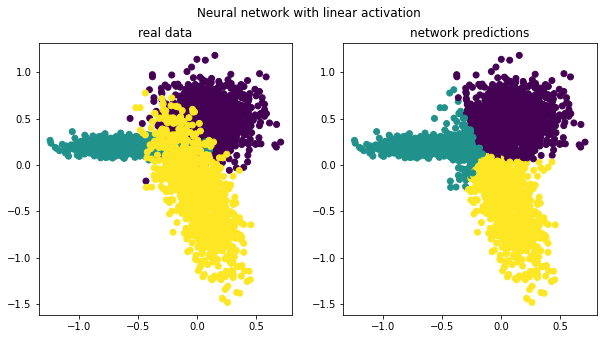

In [44]:
nn = NeuralNetwork(2, 3, loss_function='crossentropy')

# Multiple layers
nn.add_layer(5)
nn.add_layer(5)

nn.create_output_layer('softmax')
nn.errors = nn.train(X_gauss3train, y_gauss3train, epochs=20, batch_size=500, lr=.05, method='rmsprop', method_param=0.2)
pred = nn.predict(X_gauss3test)

# Plot example
y = encoder_gauss3.inverse_transform(y_gauss3test)
y_pred = encoder_gauss3.inverse_transform(pred)

fig, axis = plt.subplots(1, 2, figsize=(10,5))

axis[0].scatter(X_gauss3test[:,0].flatten(), X_gauss3test[:,1].flatten(), c = y)
axis[0].set_title('real data')
axis[1].scatter(X_gauss3test[:,0].flatten(), X_gauss3test[:,1].flatten(), c = y_pred.flatten())
axis[1].set_title('network predictions')
fig.suptitle('Neural network with linear activation')
fig.show()

In [52]:
f = open(regression + 'data.activation.train.10000.csv')
X, y = np.loadtxt(f, delimiter=",", skiprows=1, usecols=(0,1), unpack=True)
f.close()

X = (X-np.mean(X))/np.std(X)
y = (y-np.mean(y))/np.std(y)
X_activation_train = X.reshape(-1,1)
y_activation_train = y.reshape(-1,1)


f = open(regression + 'data.activation.test.10000.csv')
X, y = np.loadtxt(f, delimiter=",", skiprows=1, usecols=(0,1), unpack=True)
f.close()

X = (X-np.mean(X))/np.std(X)
y = (y-np.mean(y))/np.std(y)
X_activation_test = X.reshape(-1,1)
y_activation_test = y.reshape(-1,1)


loss on batch = 12.841081677938053
loss on batch = 11.741125897318751
loss on batch = 10.81779362017238
loss on batch = 10.46878133414664
loss on batch = 9.1493824775536
loss on batch = 8.495961889633739
loss on batch = 9.192270608683824
loss on batch = 7.013776800817001
loss on batch = 7.8419746257681595
loss on batch = 7.313673649754959
loss on batch = 7.009980682549669
loss on batch = 6.0136131123443
loss on batch = 5.345411844908861
loss on batch = 5.079478969133102
loss on batch = 4.846963369155524
loss on batch = 4.40707145627622
loss on batch = 3.696676003003825
loss on batch = 3.681560966570887
loss on batch = 3.5279941583118934
loss on batch = 3.643011916744738
loss on batch = 3.60298008469595
loss on batch = 3.7273162409377067
loss on batch = 3.499111664318277
loss on batch = 3.5844232903481306
loss on batch = 2.857166610192683
loss on batch = 3.0695055032637213
loss on batch = 3.16796117083412
loss on batch = 3.198915960439196
loss on batch = 3.133652986819021
loss on batch 

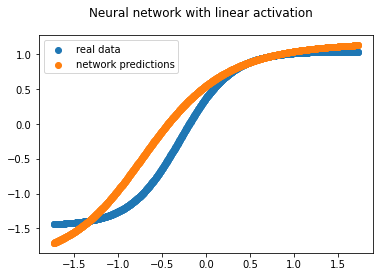

In [54]:
nn = NeuralNetwork(1, 1)

# Multiple layers
nn.add_layer(5)
nn.add_layer(5)

nn.create_output_layer()
nn.errors = nn.train(X_activation_train, y_activation_train, epochs=5, batch_size=100, lr=.05, method='rmsprop', method_param=0.2)
pred = nn.predict(X_activation_test)

# Plot example


plt.scatter(X_activation_test.flatten(), y_activation_test.flatten(), label='real data')
plt.scatter(X_activation_test.flatten(), pred.flatten(), label='network predictions')
plt.legend()
plt.suptitle('Neural network with linear activation')
plt.show()
